# 全卷积网络
:label:`sec_fcn`

如 :numref:`sec_semantic_segmentation`中所介绍的那样，语义分割是对图像中的每个像素分类。
*全卷积网络*（fully convolutional network，FCN）采用卷积神经网络实现了从图像像素到像素类别的变换 :cite:`Long.Shelhamer.Darrell.2015`。
与我们之前在图像分类或目标检测部分介绍的卷积神经网络不同，全卷积网络将中间层特征图的高和宽变换回输入图像的尺寸：这是通过在 :numref:`sec_transposed_conv`中引入的*转置卷积*（transposed convolution）实现的。
因此，输出的类别预测与输入图像在像素级别上具有一一对应关系：通道维的输出即该位置对应像素的类别预测。


In [1]:
%matplotlib inline
import warnings
from d2l import paddle as d2l

warnings.filterwarnings("ignore")
import paddle
import paddle.vision as paddlevision
from paddle import nn
from paddle.nn import functional as F

## 构造模型

下面我们了解一下全卷积网络模型最基本的设计。
如 :numref:`fig_fcn`所示，全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后在 :numref:`sec_transposed_conv`中通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。

![全卷积网络](../img/fcn.svg)
:label:`fig_fcn`

下面，我们[**使用在ImageNet数据集上预训练的ResNet-18模型来提取图像特征**]，并将该网络记为`pretrained_net`。
ResNet-18模型的最后几层包括全局平均汇聚层和全连接层，然而全卷积网络中不需要它们。


In [2]:
pretrained_net = paddlevision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

W1207 20:18:30.099810 26961 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1207 20:18:30.100975 26961 gpu_resources.cc:91] device: 0, cuDNN Version: 8.3.


INFO 2022-12-07 20:18:32,173 download.py:117] unique_endpoints {''}


INFO 2022-12-07 20:18:32,174 download.py:269] File /home/d2l-worker/.cache/paddle/hapi/weights/resnet18.pdparams md5 checking...


INFO 2022-12-07 20:18:32,347 download.py:154] Found /home/d2l-worker/.cache/paddle/hapi/weights/resnet18.pdparams


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2D(256, 512, kernel_size=[3, 3], stride=[2, 2], padding=1, data_format=NCHW)
     (bn1): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
     (relu): ReLU()
     (conv2): Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW)
     (bn2): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
     (downsample): Sequential(
       (0): Conv2D(256, 512, kernel_size=[1, 1], stride=[2, 2], data_format=NCHW)
       (1): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW)
     (bn1): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
     (relu): ReLU()
     (conv2): Conv2D(512, 512, kernel_size=[3, 3], padding=1, data_format=NCHW)
     (bn2): BatchNorm2D(num_features=512, momentum=0.9, epsilon=1e-05)
   )
 ),
 AdaptiveAvgPool2D(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000,

接下来，我们[**创建一个全卷积网络`net`**]。
它复制了ResNet-18中大部分的预训练层，除了最后的全局平均汇聚层和最接近输出的全连接层。


In [3]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

给定高度为320和宽度为480的输入，`net`的前向传播将输入的高和宽减小至原来的$1/32$，即10和15。


In [4]:
X = paddle.rand(shape=(1, 3, 320, 480))
net(X).shape

[1, 512, 10, 15]

接下来[**使用$1\times1$卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）。**]
最后需要(**将特征图的高度和宽度增加32倍**)，从而将其变回输入图像的高和宽。
回想一下 :numref:`sec_padding`中卷积层输出形状的计算方法：
由于$(320-64+16\times2+32)/32=10$且$(480-64+16\times2+32)/32=15$，我们构造一个步幅为$32$的转置卷积层，并将卷积核的高和宽设为$64$，填充为$16$。
我们可以看到如果步幅为$s$，填充为$s/2$（假设$s/2$是整数）且卷积核的高和宽为$2s$，转置卷积核会将输入的高和宽分别放大$s$倍。


In [5]:
num_classes = 21
net.add_sublayer('final_conv', nn.Conv2D(512, num_classes, kernel_size=1))
net.add_sublayer('transpose_conv', nn.Conv2DTranspose(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

Conv2DTranspose(21, 21, kernel_size=[64, 64], stride=[32, 32], padding=16, data_format=NCHW)

## [**初始化转置卷积层**]

在图像处理中，我们有时需要将图像放大，即*上采样*（upsampling）。
*双线性插值*（bilinear interpolation）
是常用的上采样方法之一，它也经常用于初始化转置卷积层。

为了解释双线性插值，假设给定输入图像，我们想要计算上采样输出图像上的每个像素。

1. 将输出图像的坐标$(x,y)$映射到输入图像的坐标$(x',y')$上。
例如，根据输入与输出的尺寸之比来映射。
请注意，映射后的$x′$和$y′$是实数。
2. 在输入图像上找到离坐标$(x',y')$最近的4个像素。
3. 输出图像在坐标$(x,y)$上的像素依据输入图像上这4个像素及其与$(x',y')$的相对距离来计算。

双线性插值的上采样可以通过转置卷积层实现，内核由以下`bilinear_kernel`函数构造。
限于篇幅，我们只给出`bilinear_kernel`函数的实现，不讨论算法的原理。


In [6]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (paddle.arange(kernel_size).reshape([-1, 1]),
          paddle.arange(kernel_size).reshape([1, -1]))
    filt = (1 - paddle.abs(og[0] - center) / factor) * \
           (1 - paddle.abs(og[1] - center) / factor)
    weight = paddle.zeros((in_channels, out_channels,
                          kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

让我们用[**双线性插值的上采样实验**]它由转置卷积层实现。
我们构造一个将输入的高和宽放大2倍的转置卷积层，并将其卷积核用`bilinear_kernel`函数初始化。


In [7]:
conv_trans = nn.Conv2DTranspose(3, 3, kernel_size=4, padding=1, stride=2,
                                bias_attr=False)
conv_trans.weight.set_value(bilinear_kernel(3, 3, 4));

读取图像`X`，将上采样的结果记作`Y`。为了打印图像，我们需要调整通道维的位置。


In [8]:
img = paddlevision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)
Y = conv_trans(X)
out_img = Y[0].transpose([1, 2, 0]).detach()

可以看到，转置卷积层将图像的高和宽分别放大了2倍。
除了坐标刻度不同，双线性插值放大的图像和在 :numref:`sec_bbox`中打印出的原图看上去没什么两样。


input image shape: [561, 728, 3]
output image shape: [1122, 1456, 3]


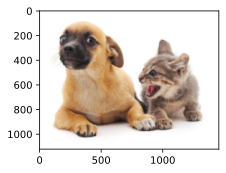

In [9]:
d2l.set_figsize()
print('input image shape:', img.transpose([1, 2, 0]).shape)
d2l.plt.imshow(img.transpose([1, 2, 0]));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

全卷积网络[**用双线性插值的上采样初始化转置卷积层。对于$1\times 1$卷积层，我们使用Xavier初始化参数。**]


In [10]:
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.set_value(W);

## [**读取数据集**]

我们用 :numref:`sec_semantic_segmentation`中介绍的语义分割读取数据集。
指定随机裁剪的输出图像的形状为$320\times 480$：高和宽都可以被$32$整除。


In [11]:
import os


def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集
    Defined in :numref:`sec_semantic_segmentation`"""
    voc_dir = d2l.download_extract('voc2012', os.path.join(
        'VOCdevkit', 'VOC2012'))
    train_iter = paddle.io.DataLoader(
        d2l.VOCSegDataset(True, crop_size, voc_dir), batch_size=batch_size,
        shuffle=True, return_list=True, drop_last=True, num_workers=0)
    test_iter = paddle.io.DataLoader(
        d2l.VOCSegDataset(False, crop_size, voc_dir), batch_size=batch_size,
        drop_last=True, return_list=True, num_workers=0)
    return train_iter, test_iter

batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

read 1114 examples


read 1078 examples


## [**训练**]

现在我们可以训练全卷积网络了。
这里的损失函数和准确率计算与图像分类中的并没有本质上的不同，因为我们使用转置卷积层的通道来预测像素的类别，所以需要在损失计算中指定通道维。
此外，模型基于每个像素的预测类别是否正确来计算准确率。


loss 0.374, train acc 0.880, test acc 0.843
176.7 examples/sec on [Place(gpu:0)]


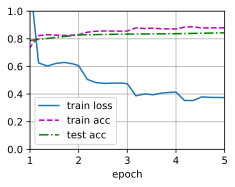

In [12]:
def loss(inputs, targets):
    return F.cross_entropy(inputs.transpose([0, 2, 3, 1]), targets, reduction='none').mean(1).mean(1)

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = paddle.optimizer.SGD(learning_rate=lr, parameters=net.parameters(), weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices[:1])

## [**预测**]

在预测时，我们需要将输入图像在各个通道做标准化，并转成卷积神经网络所需要的四维输入格式。


In [13]:
def predict(img):
    X = paddle.to_tensor(test_iter.dataset.normalize_image(img),dtype='float32').unsqueeze(0)
    pred = net(X).argmax(axis=1)
    return pred.reshape([pred.shape[1], pred.shape[2]])

为了[**可视化预测的类别**]给每个像素，我们将预测类别映射回它们在数据集中的标注颜色。


In [14]:
def label2image(pred):
    colormap = paddle.to_tensor(d2l.VOC_COLORMAP)
    X = pred.astype(paddle.int32)
    return colormap[X]

测试数据集中的图像大小和形状各异。
由于模型使用了步幅为32的转置卷积层，因此当输入图像的高或宽无法被32整除时，转置卷积层输出的高或宽会与输入图像的尺寸有偏差。
为了解决这个问题，我们可以在图像中截取多块高和宽为32的整数倍的矩形区域，并分别对这些区域中的像素做前向传播。
请注意，这些区域的并集需要完整覆盖输入图像。
当一个像素被多个区域所覆盖时，它在不同区域前向传播中转置卷积层输出的平均值可以作为`softmax`运算的输入，从而预测类别。

为简单起见，我们只读取几张较大的测试图像，并从图像的左上角开始截取形状为$320\times480$的区域用于预测。
对于这些测试图像，我们逐一打印它们截取的区域，再打印预测结果，最后打印标注的类别。


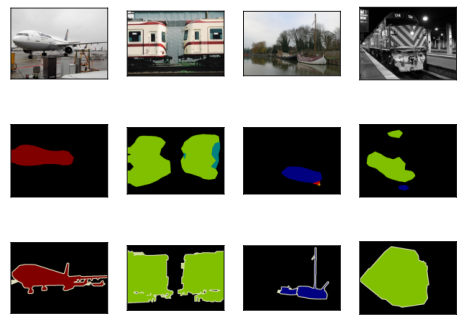

In [15]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = paddlevision.transforms.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.transpose([1,2,0]).astype('uint8'), pred,
             paddlevision.transforms.crop(
                 test_labels[i], *crop_rect).transpose([1, 2, 0]).astype("uint8")]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

## 小结

* 全卷积网络先使用卷积神经网络抽取图像特征，然后通过$1\times 1$卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。
* 在全卷积网络中，我们可以将转置卷积层初始化为双线性插值的上采样。

## 练习

1. 如果将转置卷积层改用Xavier随机初始化，结果有什么变化？
1. 调节超参数，能进一步提升模型的精度吗？
1. 预测测试图像中所有像素的类别。
1. 最初的全卷积网络的论文中 :cite:`Long.Shelhamer.Darrell.2015`还使用了某些卷积神经网络中间层的输出。试着实现这个想法。


[Discussions](https://discuss.d2l.ai/t/11811)
